In this notebook, we're attempting to shrink the label space by utilizing building footprint ROI data

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path
from osgeo import gdal, ogr, osr

%matplotlib inline

In [2]:
ROOT_PATH = Path(os.getcwd()).parent.as_posix()
DATASET_PATH = Path(ROOT_PATH, "datasets/storm-damage-detection/working").as_posix()
MAP_GTIFF_PATH = Path(DATASET_PATH, "unprep/raw/Post_Event_San_Juan.tif").as_posix()
ROI_SHAPEFILE_PATH = Path(DATASET_PATH, "unprep/building_footprint_roi/projected/building_footprint_roi_projected.shp").as_posix()
ROI_GTIFF_PATH = Path(DATASET_PATH, "unprep/building_footprint_roi/building_footprint_roi_projected.tif").as_posix()
BUILDING_COVERAGE_PATH = Path(DATASET_PATH, "unprep/building_footprint_roi/building_coverage.csv").as_posix()

In [3]:
def convert_shapefile_to_gtiff(map_path, shapefile_path, output_path):
    # Read shapefile
    shapefile_ds = ogr.Open(shapefile_path)
    shapefile_layer = shapefile_ds.GetLayer()

    # Read attributes of reference image
    map_ds = gdal.Open(map_path, gdal.GA_ReadOnly)
    map_gt = map_ds.GetGeoTransform()
    map_proj = map_ds.GetProjection()
    map_width = map_ds.RasterXSize
    map_height = map_ds.RasterYSize

    # Create output geotiff file
    output_ds = gdal.GetDriverByName("GTiff").Create(output_path, map_width, map_height, 1, gdal.GDT_Byte, options=['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES'])
    output_ds.SetProjection(map_proj)
    output_ds.SetGeoTransform(map_gt)

    # Rasterize polygons from shapefile
    band = output_ds.GetRasterBand(1)
    band.SetNoDataValue(0)
    gdal.RasterizeLayer(output_ds, [1], shapefile_layer, burn_values=[1])

    # Close dataset
    output_ds.FlushCache()
    del output_ds

In [4]:
convert_shapefile_to_gtiff(map_path=MAP_GTIFF_PATH, shapefile_path=ROI_SHAPEFILE_PATH, output_path=ROI_GTIFF_PATH)

C:\miniconda3\envs\storm-damage-detection-cuda\Lib\site-packages\osgeo\ogr.py:593: FutureWarning: Neither ogr.UseExceptions() nor ogr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [5]:
roi_ds = gdal.Open(ROI_GTIFF_PATH)
map_ds = gdal.Open(MAP_GTIFF_PATH)

print(f"{roi_ds.RasterXSize=}, {roi_ds.RasterYSize=}")
print(f"{map_ds.RasterXSize=}, {map_ds.RasterYSize=}")

roi_ds.RasterXSize=38259, roi_ds.RasterYSize=74602
map_ds.RasterXSize=38259, map_ds.RasterYSize=74602


In [6]:
grid_x = 512
grid_y = 512

roi_ds = gdal.Open(ROI_GTIFF_PATH)
width = roi_ds.RasterXSize
height = roi_ds.RasterYSize

# Calculate number of tiles in each dimension
num_tiles_x = (width // grid_x)
num_tiles_y = (height // grid_y)

print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

pos_info = []

# Iterate over each tile 
for i in range(num_tiles_x): # col index
    for j in range(num_tiles_y): # row index
        x_offset = i * grid_x
        y_offset = j * grid_y

        tile_width = min(grid_x, width - x_offset)
        tile_height = min(grid_y, height - y_offset)
        
        tile_data = roi_ds.GetRasterBand(1).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
        has_building = np.any(tile_data == 1)
        building_proportion_in_tile = np.sum(tile_data) / (grid_x * grid_y)

        pos_info.append(
            {
                "col_row": (i, j),
                "has_building": has_building,
                "coverage": building_proportion_in_tile,
                "dummy_fname": f"tile_{i}_{j}.tif"
            }
        )

Total number of tiles: 10730


In [7]:
df = pd.DataFrame(pos_info)
df

,col_row,has_building,coverage,dummy_fname
0,"(0, 0)",False,0.000000,tile_0_0.tif
1,"(0, 1)",False,0.000000,tile_0_1.tif
2,"(0, 2)",False,0.000000,tile_0_2.tif
3,"(0, 3)",False,0.000000,tile_0_3.tif
4,"(0, 4)",False,0.000000,tile_0_4.tif
...,...,...,...,...
10725,"(73, 140)",True,0.000137,tile_73_140.tif
10726,"(73, 141)",False,0.000000,tile_73_141.tif
10727,"(73, 142)",False,0.000000,tile_73_142.tif
10728,"(73, 143)",False,0.000000,tile_73_143.tif


In [8]:
df = df.sort_values(by="dummy_fname", ascending=True)
df

,col_row,has_building,coverage,dummy_fname
0,"(0, 0)",False,0.000000,tile_0_0.tif
1,"(0, 1)",False,0.000000,tile_0_1.tif
10,"(0, 10)",False,0.000000,tile_0_10.tif
100,"(0, 100)",True,0.183765,tile_0_100.tif
101,"(0, 101)",True,0.176224,tile_0_101.tif
...,...,...,...,...
1400,"(9, 95)",True,0.100235,tile_9_95.tif
1401,"(9, 96)",True,0.066277,tile_9_96.tif
1402,"(9, 97)",True,0.054447,tile_9_97.tif
1403,"(9, 98)",True,0.062675,tile_9_98.tif


In [9]:
df["file_index"] = [f"{x:03}" for x in np.arange(0, df.shape[0])]
df

,col_row,has_building,coverage,dummy_fname,file_index
0,"(0, 0)",False,0.000000,tile_0_0.tif,000
1,"(0, 1)",False,0.000000,tile_0_1.tif,001
10,"(0, 10)",False,0.000000,tile_0_10.tif,002
100,"(0, 100)",True,0.183765,tile_0_100.tif,003
101,"(0, 101)",True,0.176224,tile_0_101.tif,004
...,...,...,...,...,...
1400,"(9, 95)",True,0.100235,tile_9_95.tif,10725
1401,"(9, 96)",True,0.066277,tile_9_96.tif,10726
1402,"(9, 97)",True,0.054447,tile_9_97.tif,10727
1403,"(9, 98)",True,0.062675,tile_9_98.tif,10728


In [10]:
df = df[["file_index", "has_building", "coverage"]]
df

,file_index,has_building,coverage
0,000,False,0.000000
1,001,False,0.000000
10,002,False,0.000000
100,003,True,0.183765
101,004,True,0.176224
...,...,...,...
1400,10725,True,0.100235
1401,10726,True,0.066277
1402,10727,True,0.054447
1403,10728,True,0.062675


In [11]:
df.to_csv(BUILDING_COVERAGE_PATH, index=False)

In [12]:
df = pd.read_csv(BUILDING_COVERAGE_PATH)
df

,file_index,has_building,coverage
0,0,False,0.000000
1,1,False,0.000000
2,2,False,0.000000
3,3,True,0.183765
4,4,True,0.176224
...,...,...,...
10725,10725,True,0.100235
10726,10726,True,0.066277
10727,10727,True,0.054447
10728,10728,True,0.062675


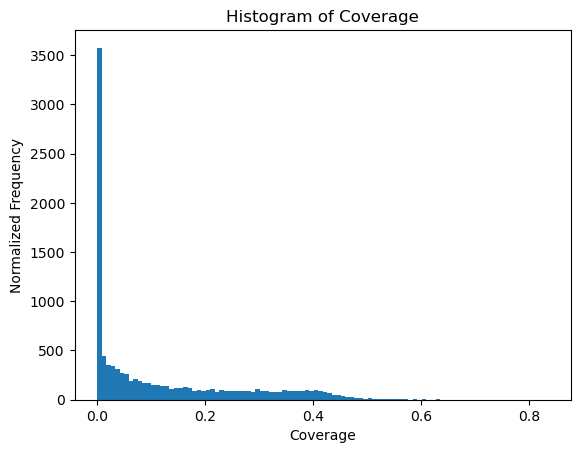

In [13]:
coverage = df["coverage"].tolist()
plt.hist(coverage, 100)
plt.xlabel('Coverage')
plt.ylabel('Normalized Frequency')
plt.title('Histogram of Coverage')
plt.show()

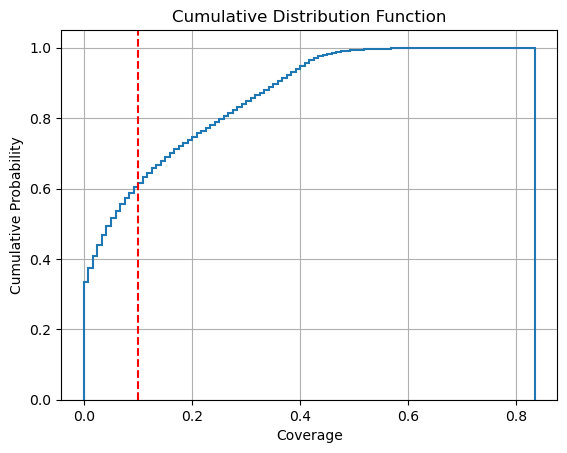

In [14]:
plt.hist(coverage, bins=100, density=True, cumulative=True, histtype='step', linewidth=1.5)
plt.axvline(x=0.1, color="r", linestyle="--")
plt.xlabel('Coverage')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function')
plt.grid(True)
plt.show()

- At least 30% of tiles have no buildings in them, it's a waste of effort if we include them in the dataset to be labelled
- Empirically, we should set the coverage threshold as **0.1**, then we can filter out more than half of the entire dataset (left with 40%)

## Create a new folder that contain the filtered grids

In [15]:
ORI_POST_EVENT_PATH = Path(DATASET_PATH, "unprep/all_grids/post_event")
NEW_POST_EVENT_PATH = Path(DATASET_PATH, "unprep/all_grids/post_event_filtered")
os.makedirs(NEW_POST_EVENT_PATH, exist_ok=True)

In [16]:
# Extract the file index of coverage >= 0.1
df_filtered = df.loc[df["coverage"] >= 0.1]
filtered_ixs = set([f"{x:03}" for x in df_filtered["file_index"].tolist()])
df_filtered

,file_index,has_building,coverage
3,3,True,0.183765
4,4,True,0.176224
8,8,True,0.105194
10,10,True,0.153507
11,11,True,0.179100
...,...,...,...
10707,10707,True,0.258598
10709,10709,True,0.214542
10710,10710,True,0.101070
10711,10711,True,0.285271


In [17]:
filtered_ixs

{'8648',
 '8948',
 '6794',
 '434',
 '1712',
 '6023',
 '7487',
 '8150',
 '409',
 '096',
 '8644',
 '10368',
 '7052',
 '9800',
 '5904',
 '8040',
 '2419',
 '1288',
 '937',
 '5616',
 '2982',
 '3354',
 '989',
 '1096',
 '7218',
 '8543',
 '8799',
 '9736',
 '3306',
 '4754',
 '6055',
 '6538',
 '6662',
 '7691',
 '8787',
 '1680',
 '5054',
 '9802',
 '5161',
 '7804',
 '2564',
 '9995',
 '3327',
 '10092',
 '5785',
 '8215',
 '2007',
 '5869',
 '10655',
 '3892',
 '10203',
 '6806',
 '8273',
 '3551',
 '10388',
 '532',
 '1720',
 '6471',
 '5468',
 '10379',
 '10518',
 '3435',
 '7914',
 '6043',
 '3117',
 '9222',
 '9566',
 '6491',
 '540',
 '1109',
 '8825',
 '1263',
 '995',
 '8070',
 '2397',
 '6071',
 '9112',
 '3805',
 '294',
 '8095',
 '399',
 '8494',
 '9825',
 '1683',
 '6385',
 '2972',
 '6801',
 '3896',
 '8965',
 '10546',
 '059',
 '4422',
 '127',
 '9453',
 '5041',
 '4709',
 '5870',
 '9531',
 '5313',
 '8978',
 '5631',
 '1251',
 '790',
 '2914',
 '6217',
 '2000',
 '9815',
 '3579',
 '10573',
 '9514',
 '9298',
 '616

In [18]:
count = 0
for fname in os.listdir(ORI_POST_EVENT_PATH):
    file_ix = fname.split("_")[-1].rstrip(".jpg")
    if not file_ix in filtered_ixs:
        continue

    # copy file to the new path
    shutil.copyfile(Path(ORI_POST_EVENT_PATH, fname), Path(NEW_POST_EVENT_PATH, fname))
    count += 1
print(f"Copied {count} files!")

Copied 4257 files!
